# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

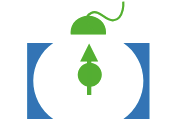

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

measure = {
    "gate": povm_measure_operator,
    "initial_params": jax.random.uniform(key=jax.random.PRNGKey(42), shape=(1,2), minval=0.0, maxval=jnp.pi)[0].tolist(),
    "measurement_flag": True,
    # "param_constraints": [[0, 0.5], [-1, 1]],
}

system_params = [measure]

result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    system_params=system_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10,
)

Iteration 0, Loss: 0.590976
Iteration 10, Loss: 0.585765
Iteration 20, Loss: 0.557517
Iteration 30, Loss: 0.561743
Iteration 40, Loss: 0.994200
Iteration 50, Loss: 0.969614
Iteration 60, Loss: 0.933662
Iteration 70, Loss: 0.995627
Iteration 80, Loss: 0.947804
Iteration 90, Loss: 0.385198
Iteration 100, Loss: 1.040835
Iteration 110, Loss: 0.264182
Iteration 120, Loss: 0.524248
Iteration 130, Loss: 0.888875
Iteration 140, Loss: 1.054750
Iteration 150, Loss: 1.212353
Iteration 160, Loss: 0.914878
Iteration 170, Loss: 1.284722
Iteration 180, Loss: 0.862867
Iteration 190, Loss: 1.126355
Iteration 200, Loss: 0.576611
Iteration 210, Loss: 0.902022
Iteration 220, Loss: 0.695964
Iteration 230, Loss: 0.759242
Iteration 240, Loss: 1.138837
Iteration 250, Loss: 0.922041
Iteration 260, Loss: 1.073270
Iteration 270, Loss: 0.774026
Iteration 280, Loss: 1.359680
Iteration 290, Loss: 1.058636
Iteration 300, Loss: 0.984048
Iteration 310, Loss: 0.666101
Iteration 320, Loss: 0.719911
Iteration 330, Loss: 

In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([1.55971101, 0.08945471], dtype=float64)], 'lookup_table': [[Array([1.26641567, 0.03547273], dtype=float64), Array([1.05376928, 0.16797944], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0.

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 7.00145750e-03+0.j  8.24300462e-02+0.j -8.25233821e-03+0.j ...
   -2.44509176e-04+0.j -1.50370309e-04+0.j -3.51468215e-04+0.j]
  [ 8.24300462e-02+0.j  9.70951166e-01+0.j -9.73082895e-02+0.j ...
   -2.87387213e-03+0.j -1.77757677e-03+0.j -4.12729701e-03+0.j]
  [-8.25233821e-03+0.j -9.73082895e-02+0.j  9.77555521e-03+0.j ...
    2.86884890e-04+0.j  1.80835076e-04+0.j  4.10919078e-04+0.j]
  ...
  [-2.44509176e-04+0.j -2.87387213e-03+0.j  2.86884890e-04+0.j ...
    8.89224194e-06+0.j  5.60030999e-06+0.j  1.24630015e-05+0.j]
  [-1.50370309e-04+0.j -1.77757677e-03+0.j  1.80835076e-04+0.j ...
    5.60030999e-06+0.j  7.03317041e-06+0.j  6.96728851e-06+0.j]
  [-3.51468215e-04+0.j -4.12729701e-03+0.j  4.10919078e-04+0.j ...
    1.24630015e-05+0.j  6.96728851e-06+0.j  1.81969160e-05+0.j]]

 [[ 9.98652379e-01+0.j -1.00013284e-02+0.j -2.64260002e-03+0.j ...
   -3.50436761e-04+0.j -4.37840138e-04+0.j -1.60406382e-04+0.j]
  [-1.00013284e-02+0.j  1.01651520e-04+0.j  2.65864104e-05+0.j ...
    3.52

In [9]:
result.optimized_trainable_parameters['lookup_table']

[[Array([1.26641567, 0.03547273], dtype=float64),
  Array([1.05376928, 0.16797944], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.]

In [10]:
# 0.8119213228423314
print(result.final_purity)

0.9163363647226792


In [11]:
from feedback_grape.utils.purity import purity

# the highest purity can be 0.995 if the initial params that initializes the lookup table
# are between 0 and pi rather than -pi and pi
print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.985463896262324
Purity of state 1: 0.9975661882929203
Purity of state 2: 0.985463896262324
Purity of state 3: 0.9975661882929203
Purity of state 4: 0.9090347538972404
Purity of state 5: 0.9355995289194351
Purity of state 6: 0.7464364797389861
Purity of state 7: 0.9052694788772864
Purity of state 8: 0.9975661882929203
Purity of state 9: 0.7033970483904343


In [12]:
result.returned_params

[[Array([[1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471],
         [1.55971101, 0.08945471]], dtype=float64)],
 [Array([[1.05376928, 0.16797944],
         [1.26641567, 0.03547273],
         [1.05376928, 0.16797944],
         [1.26641567, 0.03547273],
         [1.26641567, 0.03547273],
         [1.26641567, 0.03547273],
         [1.26641567, 0.03547273],
         [1.05376928, 0.16797944],
         [1.26641567, 0.03547273],
         [1.26641567, 0.03547273]], dtype=float64)],
 [Array([[1.28111854, 0.22409544],
         [1.1337725 , 0.02764423],
         [1.28111854, 0.22409544],
         [1.1337725 , 0.02764423],
         [1.32666175, 0.27598879],
         [1.1337725 , 0.02764423],
         [1.32666175, 0.27598879],
         [0.9997156

In [13]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]


[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [14]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [1.55971101 0.08945471]
purity of rho after time step 0 0.38319032511664786
params for time step 1: [1.05376928 0.16797944]
purity of rho after time step 1 0.40285023438502326
params for time step 2: [1.28111854 0.22409544]
purity of rho after time step 2 0.4944976171578525
params for time step 3: [1.4128944  0.32545153]
purity of rho after time step 3 0.6301177872847299
params for time step 4: [1.41767334 0.37908826]
purity of rho after time step 4 0.6944101723027681


In [15]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [16]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 1.14904656e-03+0.j  4.03900244e-03+0.j  2.29544594e-03+0.j
   2.64146335e-02+0.j -2.65400281e-03+0.j  1.26441287e-03+0.j
  -1.15906796e-03+0.j -7.55323367e-04+0.j -3.70558546e-04+0.j
  -6.62400671e-04+0.j -6.29561685e-04+0.j -4.43069874e-04+0.j
  -5.92739145e-04+0.j -3.08928092e-04+0.j -3.78959068e-04+0.j
  -3.21119042e-04+0.j -1.73902167e-04+0.j -2.60631523e-04+0.j
  -2.16371023e-04+0.j -1.22322014e-04+0.j -1.76746270e-04+0.j
  -6.07677011e-05+0.j -1.82236715e-04+0.j -1.75451888e-04+0.j
  -1.18299831e-04+0.j -7.52707924e-05+0.j -9.28016601e-05+0.j
  -6.03761047e-05+0.j -1.25204528e-04+0.j -9.32457475e-05+0.j]
 [ 4.03900244e-03+0.j  3.63601194e-02+0.j  3.49505667e-04+0.j
   3.60166750e-02+0.j -4.92096706e-03+0.j  1.53155886e-03+0.j
  -2.10897973e-03+0.j -1.83452383e-03+0.j -5.20810414e-04+0.j
  -1.65201377e-03+0.j -1.80530668e-03+0.j -1.02244809e-03+0.j
  -2.31530839e-03+0.j -6.02952052e-04+0.j -1.08708315e-03+0.j
  -6.62435533e-04+0.j -3

In [17]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 7.00145750e-03+0.j  8.24300462e-02+0.j -8.25233821e-03+0.j ...
   -2.44509176e-04+0.j -1.50370309e-04+0.j -3.51468215e-04+0.j]
  [ 8.24300462e-02+0.j  9.70951166e-01+0.j -9.73082895e-02+0.j ...
   -2.87387213e-03+0.j -1.77757677e-03+0.j -4.12729701e-03+0.j]
  [-8.25233821e-03+0.j -9.73082895e-02+0.j  9.77555521e-03+0.j ...
    2.86884890e-04+0.j  1.80835076e-04+0.j  4.10919078e-04+0.j]
  ...
  [-2.44509176e-04+0.j -2.87387213e-03+0.j  2.86884890e-04+0.j ...
    8.89224194e-06+0.j  5.60030999e-06+0.j  1.24630015e-05+0.j]
  [-1.50370309e-04+0.j -1.77757677e-03+0.j  1.80835076e-04+0.j ...
    5.60030999e-06+0.j  7.03317041e-06+0.j  6.96728851e-06+0.j]
  [-3.51468215e-04+0.j -4.12729701e-03+0.j  4.10919078e-04+0.j ...
    1.24630015e-05+0.j  6.96728851e-06+0.j  1.81969160e-05+0.j]]

 [[ 9.98652379e-01+0.j -1.00013284e-02+0.j -2.64260002e-03+0.j ...
   -3.50436761e-04+0.j -4.37840138e-04+0.j -1.60406382e-04+0.j]
  [-1.00013284e-02+0.j  1.01651520e-04+0.j  2.6586

In [18]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [19]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [20]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [21]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [22]:
batch_size = 2

In [23]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [24]:
rho_final_batched.shape

(2, 30, 30)

In [25]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [26]:
rng_keys[0].shape

(2,)

In [27]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]


In [28]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


In [29]:
initial_params = {
    "qubit_unitary": [0.1, 0.1],
    "qubit_cavity_unitary": [0.2, 0.2],
}
param_constraints = [[[0, 0.5], [0.5, 1.0]], [[1.0, 1.5], [1.5, 2.0]]]



In [30]:
def construct_ragged_row(num_of_rows, num_of_columns, param_constraints, rng_key):
    res = []
    for i in range(num_of_rows):
        row = []
        for j in range(num_of_columns):
            rng_key, subkey = jax.random.split(rng_key)
            val = jax.random.uniform(
                subkey,
                shape=(),
                minval=param_constraints[j][0],
                maxval=param_constraints[j][1],
            )
            row.append(val)
        res.append(jnp.array(row))
    return res

In [31]:
h_initial_state = None
rnn_model = None
# step 1: initialize the parameters
num_of_columns = 4
num_of_sub_lists = 1 * 5
F = []
param_constraints_reshaped = jnp.array(param_constraints).reshape(-1, 2)
# construct ragged lookup table
row_key = jax.random.PRNGKey(0)
for i in range(1, num_of_sub_lists + 1):
    row_key, _ = jax.random.split(row_key)
    F.append(
        construct_ragged_row(
            num_of_rows=2**i,
            num_of_columns=num_of_columns,
            param_constraints=param_constraints_reshaped,
            rng_key=row_key,
        )
    )
# step 2: pad the arrays to have the same number of rows
min_num_of_rows = 2 ** len(F)
for i in range(len(F)):
    if len(F[i]) < min_num_of_rows:
        zeros_arrays = [
            jnp.zeros((num_of_columns,), dtype=jnp.float64)
            for _ in range(min_num_of_rows - len(F[i]))
        ]
        F[i] = F[i] + zeros_arrays

F

[[Array([0.33559649, 0.67583317, 1.07987065, 1.98053433], dtype=float64),
  Array([0.11240873, 0.64456978, 1.07282654, 1.92680755], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0.,

In [32]:
def construct_ragged_row(num_of_rows, num_of_columns, param_constraints, rng_key):
    res = []
    for i in range(num_of_rows):
        print(param_constraints[0][0])
        flattened = jax.random.uniform(
            rng_key,
            shape=(num_of_columns,),
            minval=param_constraints[i][0],
            maxval=param_constraints[i][1],
            dtype=jnp.float64,
        )
        res.append(flattened)
    return res


In [33]:
param_constraints =  [[0, 0.5]],
